In [107]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
                # print( f"Value(data={v})")
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s| data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [108]:
import math
class Value:
    def __init__(self,data, _children=(),_op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self._backward = lambda:None
        
    def __repr__(self):
        return f"Value(data={self.data, self.label})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self, other),'+')
        # contained propagation
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
        
        
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        # contained propagation
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (( other * self.data ** (other-1)) *  out.grad) 
        out._backward = _backward
        return out
        
    def __rmul__(self,other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
        
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1 )/ (math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        # contained propagation, only single not other.
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        # contained propagation, only single not other.
        def _backward():
            self.grad += (out.data * out.grad)
        out._backward = _backward
        return out
        
    # Overall backward to all
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

   

    
    
    

# Implement Neural network , 2 Layer perceptron.

In [109]:
import random


class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self,nin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.nin = nin
    
    def __call__(self,x):
        # w*x +b 
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

    def __call__(self, x ):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [110]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1337)
random.seed(1337)



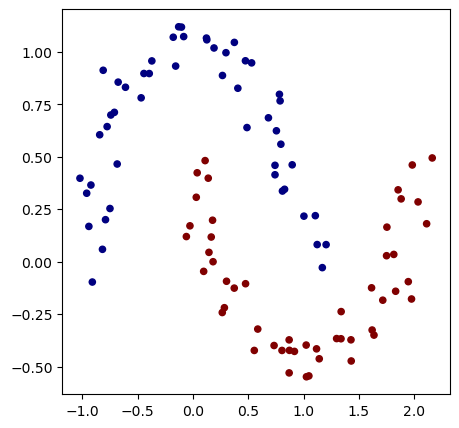

In [111]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=.1)
y = y*2 -1 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [112]:
model = MLP(2, [16,16,1])
print(model)
print("number of parameters" , len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [ReLUNeuron(16)]]
number of parameters 337


In [113]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value,xrow)) for xrow in Xb]

    scores = list(map(model, inputs))

    losses = [(1 + - yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0/ len(losses))

    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy)/len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7840043023159258, grad=0) 0.68


In [114]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    #backward
    model.zero_grad()
    total_loss.backward()

    #update
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k %1 ==0 :
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}")

step 0 loss 0.7840043023159258, accuracy 68.0
step 1 loss 0.5346887893624205, accuracy 73.0
step 2 loss 0.40486112398826374, accuracy 83.0
step 3 loss 0.3380828095624803, accuracy 86.0
step 4 loss 0.2942618979033042, accuracy 88.0
step 5 loss 0.27137071884535235, accuracy 90.0
step 6 loss 0.2557758037037018, accuracy 90.0
step 7 loss 0.24353269446140005, accuracy 91.0
step 8 loss 0.2331166633588174, accuracy 91.0
step 9 loss 0.22371429713875027, accuracy 91.0
step 10 loss 0.21478840620418216, accuracy 91.0
step 11 loss 0.20603142190103887, accuracy 91.0
step 12 loss 0.1972226427758724, accuracy 92.0
step 13 loss 0.18824544635214926, accuracy 93.0
step 14 loss 0.17902966856680746, accuracy 94.0
step 15 loss 0.16967500545392217, accuracy 94.0
step 16 loss 0.1603343984865978, accuracy 94.0
step 17 loss 0.15200986278726358, accuracy 96.0
step 18 loss 0.14550876426551504, accuracy 96.0
step 19 loss 0.15276142639895662, accuracy 95.0
step 20 loss 0.14406510423987695, accuracy 96.0
step 21 lo

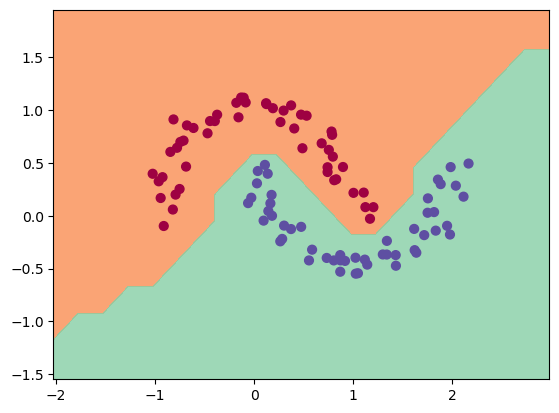

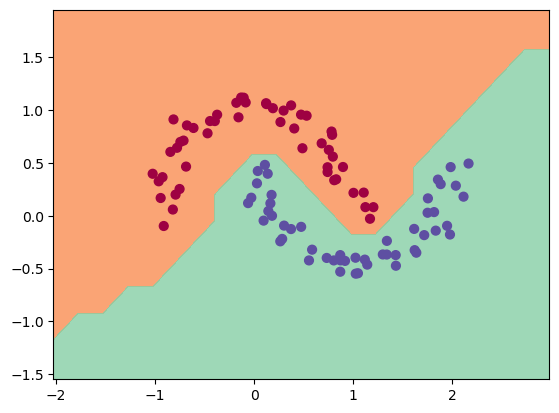

In [116]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()